# Method Validation

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import poisson
from scipy import signal, stats
from scipy.spatial.distance import cosine, euclidean, directed_hausdorff

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.io import wavfile
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

import os
import h5py
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_root = os.path.join('..', '..', 'data', 'anesthetized')
data_root

'..\\..\\data\\anesthetized'

In [3]:
df = pd.read_csv('aa-4.csv')
df.sample(n=1)

,subject,site,single_unit,sortType,stim_number,original_wavfile,callerAge,callid,stim_duration,stim_source,stim_source_sex,stim_type,brain_region,hemisphere,vocid,auditory_cortex
37852,GreBlu9508M,Site4,Site4_L1500R1900_e2_s0_ss1,single,272,WhiLbl0010_MAS_Ne_10-4-9.wav,A,Ne,2.5,unfamiliar,m,call,CMM,L,Ne,A2


## Utility Functions

### Get Biological Neural Responses for Comparison

In [4]:
# returns a matrix of shape (n_trials, n_neurons).
def getPopulationResponse(bird, stim_number, hemisphere='L', site='Site2'):
    resp_df = df[(df['subject']==bird) & (df['stim_number']==stim_number) & (df['hemisphere']==hemisphere) & (df['site']==site)]
    
    # load data
    cells = resp_df['single_unit'].unique()
    population_response = []
    
    # cell == neuron
    for cell in cells:
        # load cell
        source_path = os.path.join(data_root, bird, cell+'.h5')
        neuron_data = h5py.File(source_path)
        main_key = [k for k in neuron_data.keys() if k.__contains__('Call')][0]
        
        # load response
        cell_response = []
        trialIDs = neuron_data[main_key][str(stim_number)].keys()
        for trialID in trialIDs:
            trial_response = neuron_data[main_key][str(stim_number)][trialID]['spike_times'][:]
            cell_response.append(trial_response)
        
        population_response.append(cell_response)
    population_response = np.array(population_response)
    return np.swapaxes(population_response, 0, 1)    # since neuron is in the outer loop, original shape is (n_neurons, n_trials)

response = getPopulationResponse('GreBlu9508M', stim_number=101)
response.shape

(9, 23)

In [5]:
# returns a matrix of shape (n_trials, n_neurons, n_timesteps)
def times2trains(population_response, start=0, end=450):
    trial_count = population_response.shape[0]
    neuron_count = population_response.shape[1]
    
    spike_trains = np.zeros((trial_count, neuron_count, 450))
    for i, trial in enumerate(population_response):
        for j, neuron in enumerate(trial):
            for k, time in enumerate(neuron):
                if time >= -999:    # NaNs are stored as -999 in the data
                    time = np.clip(time, -1, 3.49)
                    spike_trains[i, j, 100+int(np.round(time*100))] += 1
    return spike_trains[:, :, start:end]

spike_trains = times2trains(response, start=100, end=350)
spike_trains.shape

(9, 23, 250)

Text(0.5, 1.0, 'Spike train from a real neuron')

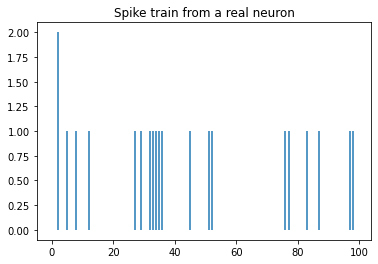

In [253]:
plt.vlines(np.arange(100), 0, spike_trains[0][14][:100])
plt.title('Spike train from a real neuron')

### Extract Acoustic Features

In [18]:
def get_features(myBioSound):
    feature_vector = np.array([
                              # Pitch features
                              myBioSound.fund, myBioSound.meansal, myBioSound.maxfund, 
                              myBioSound.minfund, myBioSound.cvfund, 

                              # Shape of spectral envelope
                              myBioSound.meanspect, myBioSound.stdspect,
                              myBioSound.skewspect, myBioSound.kurtosisspect, myBioSound.entropyspect,
                              myBioSound.q1, myBioSound.q2, myBioSound.q3,

                              # Shape and magnitude of amplitude envelope
                              myBioSound.meantime, myBioSound.stdtime,
                              myBioSound.skewtime, myBioSound.kurtosistime, myBioSound.entropytime,
                              myBioSound.rms, myBioSound.maxAmp])
    feature_vector = np.reshape(feature_vector, (1, 20))
    return feature_vector

### Generate Synthetic Dataset

In [23]:
def get_synthetic_dataset(bird, hemisphere='L', auditory_cortex='A2', n_timesteps=None):
    resp_df = df[(df['subject']==bird) & (df['hemisphere']==hemisphere) & (df['auditory_cortex']==auditory_cortex)]

    # load data
    cells = resp_df['single_unit'].unique()
    callids = resp_df['callid'].unique()
    X_features, X_response, y = np.empty((0, 1, 20)), np.empty((0, 1, 20)), np.empty((0))
    
    for callid in tqdm(callids):
        stimuli = resp_df[resp_df['callid']==callid]['stim_number'].unique()
        for stimulus in stimuli[:3]:
            filepath = os.path.join(data_root, bird, 'wavfiles', 'stim'+str(stimulus)+'.wav')
            
            soundIn = WavFile(file_name=filepath, mono=True)

            # Create BioSound Object
            myBioSound = BioSound(soundWave=soundIn.data.astype(float), fs=soundIn.sample_rate)

            # Calculate the spectrogram and the rms
            myBioSound.spectroCalc(spec_sample_rate=1000, freq_spacing = 50, min_freq=0, max_freq=10000)
            myBioSound.rms = myBioSound.sound.std() 

            # Calculate amplitude enveloppe
            myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 1000)

            # Calculate the power spectrum
            myBioSound.spectrum(f_high=2000)

            # Calculate fundamental and related values.  These are the default values.
            # For the estimation of the fundamental, four methods are available: 
            # 'AC' - Peak of the auto-correlation function
            # 'ACA' - Peak of envelope of auto-correlation function 
            # 'Cep' - First peak in cepstrum 
            # 'Stack' - Fitting of harmonic stacks (default - works well for zebra finches)

            myBioSound.fundest(maxFund = 1500, minFund = 300, lowFc = 200, highFc = 2000, 
                               minSaliency = 0.5, debugFig = 0, 
                               minFormantFreq = 500, maxFormantBW = 500, windowFormant = 0.1,
                               method='Stack')

            # Calculate the MPS
            myBioSound.mpsCalc(window=0.1, Norm = True)
            
            feature_vector = get_features(myBioSound)
            feature_vector = np.expand_dims(feature_vector, axis=0)
            X_features = np.append(X_features, feature_vector, axis=0)
            y = np.append(y, callid)
    
    
    scaler = MinMaxScaler(feature_range=(0.005, 0.500))
    X_features_scaled = scaler.fit_transform(X_features[:, 0, :])
    for feature_vector in X_features_scaled:
        neural_response = []
        for i in range(feature_vector.shape[-1]):
            mu = np.maximum(feature_vector[i] + np.random.default_rng().normal(scale=feature_vector[i]*0.50), 0)
            r = poisson.rvs(mu, size=100)
            spike_count = np.sum(r)
            neural_response.append(spike_count)
        neural_response = np.array(neural_response)
        neural_response = np.reshape(neural_response, (1, 1, 20))
        X_response = np.append(X_response, neural_response, axis=0)
    
    return X_features, X_response, y

In [232]:
# use this block to recalculate X_reponse if you want to change noise level
X_response = np.empty((0, 1, 20))
X_trains = np.empty((0, 100, 20))
scaler = MinMaxScaler(feature_range=(0.005, 0.500))
X_features_scaled = scaler.fit_transform(X_features[:, 0, :])
for feature_vector in X_features_scaled:
    neural_response, spike_train = [], []
    for i in range(feature_vector.shape[-1]):
        mu = np.maximum(feature_vector[i] + np.random.default_rng().normal(scale=feature_vector[i]*0.50), 0)
        r = poisson.rvs(mu, size=100)
        spike_count = np.sum(r)
        
        neural_response.append(spike_count)
        spike_train.append(r)
        
    neural_response = np.array(neural_response)
    neural_response = np.reshape(neural_response, (1, 1, 20))
    spike_train = np.array(spike_train)
    spike_train = np.reshape(spike_train, (1, 100, 20))
    
    X_response = np.append(X_response, neural_response, axis=0)
    X_trains = np.append(X_trains, spike_train, axis=0)

### Distance Matrix

In [114]:
def get_distance_matrix(X, y):
    X = np.squeeze(X)
    unique_categories = np.unique(y)
    num_categories = len(unique_categories)
    dist_matrix = np.zeros((num_categories, num_categories))

    sample_labels = []
    category_indices = {}  # To keep track of the category indices and sample counts.
    
    # pick first category
    for i, cat_1 in enumerate(unique_categories):
        X_1 = X[y == cat_1]
        # pick second category
        for j, cat_2 in enumerate(unique_categories):
            X_2 = X[y == cat_2]

            dist_matrix[i, j] = directed_hausdorff(X_1, X_2)[0]
    return dist_matrix

### Mantel Test

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from random import sample

## permutation the index of a matrix; m1 is a data frame
def perm_rowscols(m1, n):
    m1 = pd.DataFrame(np.array(m1))
    s = sample(range(n), n)
    return m1.iloc[s,s]

def mantel_r(m1, m2):
    m1 = np.array(m1)
    m2 = np.array(m2)
    
    m1 = m1[np.where(~np.eye(m1.shape[0], dtype=bool))].flatten()
    m2 = m2[np.where(~np.eye(m2.shape[0], dtype=bool))].flatten()
    r = stats.pearsonr(m1, m2)[0]
    return r

## the mantel test of two matrices, m1 and m2 are two data frames
def mantel_test(m1, m2, nperm=100, alternative = "two.sided"):
    m1 = pd.DataFrame(np.array(m1))
    m2 = pd.DataFrame(np.array(m2))
    mantel_output = {"r.stat": -1, "p": -1, "alternative": alternative}
    #check whether the number of rows and columns are same between m1 and m2
    if ( (m1.shape[0] == m2.shape[0]) and ((m1.shape[1] == m2.shape[1])) ):
        n = m2.shape[0]
        realr = mantel_r(m1, m2)

        nullstats = []
        for ii in range(nperm):
            m2perm = perm_rowscols(m2, n)
            permr = mantel_r(m1, m2perm)
            nullstats.append(permr)
            
        lessNum = [num for num in nullstats if num <= realr]
        greaterNum = [num for num in nullstats if num >= realr]
        if (alternative == "less"):
            pval = len(lessNum)
        elif (alternative == "greater"):
            pval = len(greaterNum)
        elif (alternative == "two.sided"):
            pval = 2*min([len(lessNum), len(greaterNum)])
        else:
            pval = -1*nperm
            print("Please set the alernative as 'less', 'greater', or 'two.sided'\n.")
        # 'realr' is included in 'nullstats'
        pval = (pval + 1)/(nperm + 1)
        if ( (alternative == "two.sided") and (pval >1) ):
            pval = 1
        mantel_output["r.stat"] = realr
        mantel_output["p"] = pval

    else:
        print("The dimensions of two matrices are not equal.\n")
    return mantel_output, nullstats

### Mantel Test Plotting Function

In [41]:
import numpy as np
from scipy import stats

def confidence_interval(result, alpha=0.05):
    """
    Return the confidence interval in a normal distribution(characterized by
    its given mean and its given standard deviation) for rejecting the null
    hypothesis with some given significance level and some given tail
    method.

    Parameters
    ----------
    result : float
        MantelResult object
    alpha : float (between 0 and 1), optional
        The probability of rejecting the null hypothesis when it is true
        (default: 0.05).

    Returns
    -------
    lower_bound : float
        Lower bound of the confidence interval.
    upper_bound : float
        Upper bound of the confidence interval.
    """
    if not (0 < alpha < 1):
        raise ValueError("The alpha level must be in the interval (0, 1)")
    if result.tail == "upper":
        lower_bound = stats.norm.ppf(1e-10, result.mean, result.std)
        upper_bound = stats.norm.ppf(1 - alpha, result.mean, result.std)
    elif result.tail == "lower":
        lower_bound = stats.norm.ppf(alpha, result.mean, result.std)
        upper_bound = stats.norm.ppf(1 - 1e-10, result.mean, result.std)
    elif result.tail == "two-tail":
        lower_bound = stats.norm.ppf(alpha / 2, result.mean, result.std)
        upper_bound = stats.norm.ppf(1 - alpha / 2, result.mean, result.std)
    return lower_bound, upper_bound

def plot(
    result,
    axis=None,
    alpha=0.05,
    hist_color="lightgray",
    gaussian_color="black",
    acceptance_color="black",
    rejection_color="black",
):
    """
    Plot a histogram of the sample correlations from a MantelResult object on
    a Matplotlib axis. If no axis is provided, a new plot is created and
    returned. The theoretical normal distribution (and confidence interval)
    is also shown, along with the veridical correlation.

    Parameters
    ----------
    result : MantelResult
        The reuslt object output from mantel.test()
    axis : matplotlib.axes.Axes
        The matplotlib figure to draw on.
    alpha : float
        Significance level for rejecting the null hypothesis (default: 5%)
    hist_color: str
        Color used for the histogram bars (default: 'lightgray').
    gaussian_color: str
        Color used for the normal distribution curve and the confidence
        interval limits (default: 'black').
    acceptance_color: str
        Color used for drawing the vertical line and the label of the
        veridical correlation if the null hypothesis is rejected according to
        the significance level value (default: 'black').
    rejection_color: str
        Color used for drawing the vertical line and the label of the
        veridical correlation if the null hypothesis cannot be rejected
        according to the significance level value (default: 'black').

    Returns
    -------
    Matplotlib Figure and Axis objects
    """
    if plt is None:
        raise ImportError("Matplotlib is required for plotting")
    if axis is None:
        fig, axis = plt.subplots()
    elif isinstance(axis, Axes):
        fig = axis.get_figure()
    else:
        raise TypeError("axis should be a Matplotlib Axis object")

    lower = -1.05
    upper = 1.05

    n_bins = 100 if result.perms >= 1000 else 20
    axis.hist(
        result.correlations,
        bins=n_bins,
        range=(lower, upper),
        density=True,
        histtype="stepfilled",
        color=hist_color,
    )

    x = np.linspace(lower, upper, 200)
    y = stats.norm.pdf(x, result.mean, result.std)
    axis.plot(x, y, color=gaussian_color)

    min_corr, max_corr = confidence_interval(result, alpha)
    axis.vlines(
        x=[min_corr, max_corr],
        ymin=0,
        ymax=[
            stats.norm.pdf(min_corr, result.mean, result.std),
            stats.norm.pdf(max_corr, result.mean, result.std),
        ],
        linestyle="-",
        color=gaussian_color,
    )

    threshold_color = (
        rejection_color if min_corr <= result.r <= max_corr else acceptance_color
    )
    axis.axvline(x=result.r, linestyle=":", color=threshold_color)
    #axis.annotate("{:.2f}".format(result.r), xy=(result.r, 0.9), color=threshold_color)

    axis.set_xlim(lower, upper)
    axis.set_title('Mantel Test', fontsize=24)
    axis.set_xlabel("Correlation coefficient", fontsize=20)
    axis.set_ylabel("Probability Density", fontsize=20)
    #axis.set_yticks([])
    #labels = axis.get_xticklabels()
    #axis.set_xticklabels(labels, fontsize=10)
    axis.tick_params(axis='x', labelsize=14)
    axis.tick_params(axis='y', labelsize=14)
    return fig, axis

## Analysis

In [26]:
%%capture
X_features, X_response, y = get_synthetic_dataset('WhiWhi4522M')

In [229]:
X_features.shape

(24, 1, 20)

In [228]:
X_response.shape

(24, 1, 20)

In [212]:
scaler = MinMaxScaler()
X_features_scaled = np.expand_dims(scaler.fit_transform(X_features[:, 0, :]), axis=1)
X_features_scaled.shape

(24, 1, 20)

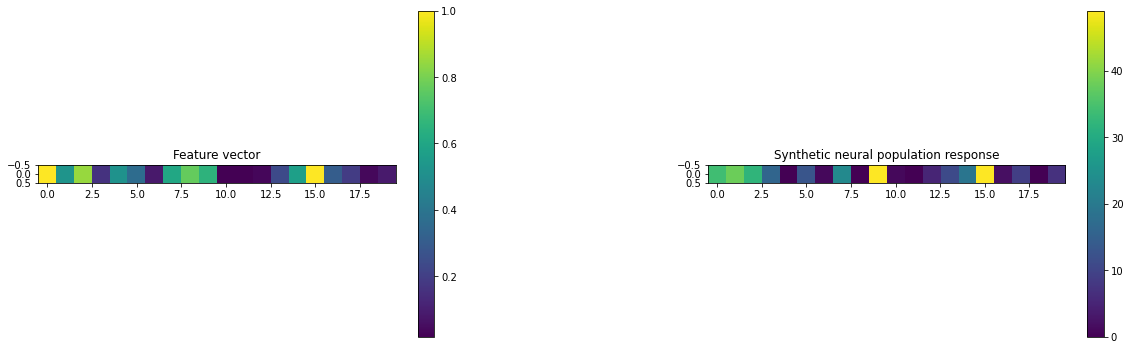

In [227]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
#fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)

axes[0].title.set_text('Feature vector')
features_plot = axes[0].imshow(X_features_scaled[2, :, :])
plt.colorbar(features_plot, ax=axes[0])

axes[1].title.set_text('Synthetic neural population response')
response_plot_1 = axes[1].imshow(X_response[2, :, :])
plt.colorbar(response_plot_1, ax=axes[1])

In [241]:
X_trains = np.swapaxes(X_trains, 1, 2)

Text(0.5, 1.0, 'Spike Raster Plot')

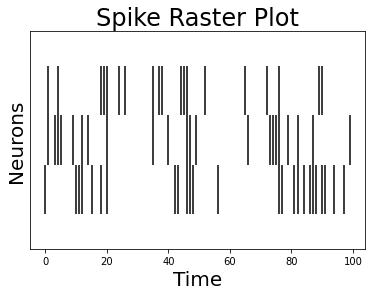

In [242]:
plt.eventplot([np.append(np.nonzero(X_trains[10][0])[0], 20), np.append(np.nonzero(X_trains[2][0])[0], 20), np.append(np.nonzero(X_trains[0][0])[0], 20)], color='k')

plt.xlabel('Time', fontsize=20)
plt.tick_params(left = False, right = False, labelleft = False)
plt.ylabel('Neurons', fontsize=20)
plt.title('Spike Raster Plot', fontsize=24)

In [197]:
features_distance_matrix = get_distance_matrix(X_features_scaled, y)

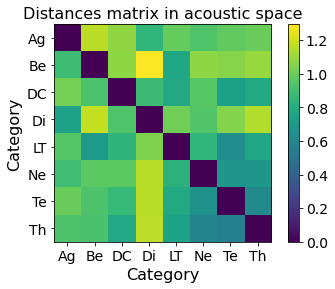

In [198]:
# Plot the distances as a heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(features_distance_matrix, cmap='viridis')

# Customize the plot
categories = np.unique(y)
ax.set_xticks(np.arange(8))
ax.set_yticks(np.arange(8))
ax.set_xticklabels(categories, fontsize=14)
ax.set_yticklabels(categories, fontsize=14)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Category', fontsize=16)
plt.title('Distances matrix in acoustic space', fontsize=16)
cbar = plt.colorbar(heatmap, ax=ax)
cbar.ax.tick_params(labelsize=14)

# Show the plot
plt.show()

In [199]:
neural_distance_matrix = get_distance_matrix(X_response, y)

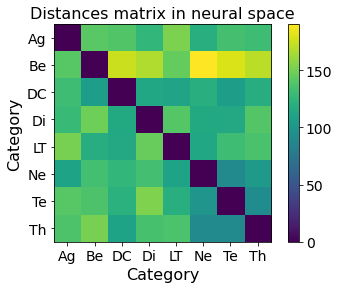

In [200]:
# Plot the distances as a heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(neural_distance_matrix, cmap='viridis')

# Customize the plot
ax.set_xticks(np.arange(8))
ax.set_yticks(np.arange(8))
ax.set_xticklabels(categories, fontsize=14)
ax.set_yticklabels(categories, fontsize=14)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Category', fontsize=16)
plt.title('Distances matrix in neural space', fontsize=16)
cbar = plt.colorbar(heatmap, ax=ax)
cbar.ax.tick_params(labelsize=14)
# Show the plot
plt.show()

In [201]:
output, corrs = mantel_test(pd.DataFrame(features_distance_matrix), pd.DataFrame(neural_distance_matrix), nperm=1000)
output

{'r.stat': 0.7003130139627465,
 'p': 0.000999000999000999,
 'alternative': 'two.sided'}

In [202]:
result = type('obj', (object,), {'correlations': corrs, 'perms': len(corrs), 'tail': 'upper', 'mean': np.mean(corrs), 'std': np.std(corrs), 'r': output['r.stat']})

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Mantel Test'}, xlabel='Correlation coefficient', ylabel='Probability Density'>)

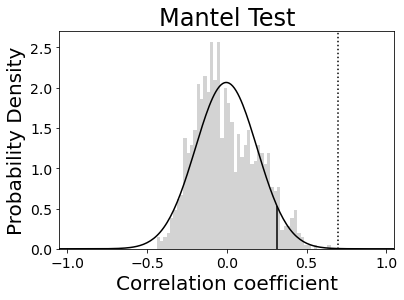

In [203]:
plot(result)
#plt.title('Mantel Test Result: Synthetic Data')